# <center>Diabetic Retinopathy Detection <center>

### Importing Libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt

### Transfer Learning using VGG16

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.utils import class_weight

In [19]:
!unzip "/content/drive/My Drive/Dataset_original.zip" -d "/content"

Archive:  /content/drive/My Drive/Dataset_original.zip
   creating: /content/Dataset/Mild/
  inflating: /content/Dataset/Mild/0024cdab0c1e.png  
  inflating: /content/Dataset/Mild/00cb6555d108.png  
  inflating: /content/Dataset/Mild/0124dffecf29.png  
  inflating: /content/Dataset/Mild/01b3aed3ed4c.png  
  inflating: /content/Dataset/Mild/0369f3efe69b.png  
  inflating: /content/Dataset/Mild/03e25101e8e8.png  
  inflating: /content/Dataset/Mild/04ac765f91a1.png  
  inflating: /content/Dataset/Mild/059bc89df7f4.png  
  inflating: /content/Dataset/Mild/05a5183c92d0.png  
  inflating: /content/Dataset/Mild/0684311afdfc.png  
  inflating: /content/Dataset/Mild/06b71823f9cd.png  
  inflating: /content/Dataset/Mild/07929d32b5b3.png  
  inflating: /content/Dataset/Mild/07a1c7073982.png  
  inflating: /content/Dataset/Mild/086d41d17da8.png  
  inflating: /content/Dataset/Mild/09935d72892b.png  
  inflating: /content/Dataset/Mild/0a3202889f4d.png  
  inflating: /content/Dataset/Mild/0a61bddab9

In [43]:
import glob
images_data = glob.glob("Dataset/*/*.png")
len(images_data)

3662

#### Contrast Limited Adaptive Histogram Equalization

In [51]:
def apply_clahe(path):
    img = cv2.imread(path)
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    hsv_planes = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hsv_planes[2] = clahe.apply(hsv_planes[2])
    hsv = cv2.merge(hsv_planes)
    cv2.imwrite(path,cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR))

In [55]:
for image in images_data:
    apply_clahe(image)

In [56]:
# Defining constants
DIR = "Dataset"
IMAGE_SIZE = [224,224]
BATCH_SIZE = 32

In [57]:
gen = ImageDataGenerator(rotation_range=0,
                        preprocessing_function=preprocess_input,
                         validation_split=0.2)

In [58]:
train_generator = gen.flow_from_directory(
    DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='training') # set as training data

Found 2931 images belonging to 5 classes.


In [84]:
validation_generator = gen.flow_from_directory(
    DIR, 
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=BATCH_SIZE,
    subset='validation') # set as validation data

Found 731 images belonging to 5 classes.


In [60]:
# Transfer Learning
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [61]:
for layer in model.layers:
    layer.trainable = False
# Making last 16 layers trainable
for layer in model.layers[-16:]:
    layer.trainable = True

In [62]:
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy'])
model.summary()  

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [63]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

In [64]:
from collections import Counter
counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 4.878378378378378,
 1: 1.805,
 2: 1.0,
 3: 6.11864406779661,
 4: 9.316129032258065}

In [65]:
hist = model.fit(train_generator, steps_per_epoch=train_generator.samples//train_generator.batch_size, 
                 validation_data=validation_generator, 
                 class_weight=class_weights, 
                 validation_steps=validation_generator.samples//validation_generator.batch_size, 
                 epochs=80,
                 callbacks=[early])

Epoch 1/80
91/91 [==============================] - 30s 326ms/step - loss: 3.6647 - accuracy: 0.4998 - val_loss: 0.9393 - val_accuracy: 0.6094
Epoch 2/80
91/91 [==============================] - 27s 300ms/step - loss: 2.6027 - accuracy: 0.6713 - val_loss: 0.8156 - val_accuracy: 0.6875
Epoch 3/80
91/91 [==============================] - 27s 298ms/step - loss: 2.2684 - accuracy: 0.7327 - val_loss: 0.7162 - val_accuracy: 0.7244
Epoch 4/80
91/91 [==============================] - 27s 301ms/step - loss: 2.0013 - accuracy: 0.7651 - val_loss: 0.7082 - val_accuracy: 0.7244
Epoch 5/80
91/91 [==============================] - 27s 302ms/step - loss: 1.7797 - accuracy: 0.7875 - val_loss: 0.6864 - val_accuracy: 0.7259
Epoch 6/80
91/91 [==============================] - 27s 300ms/step - loss: 1.5695 - accuracy: 0.8241 - val_loss: 0.6682 - val_accuracy: 0.7372
Epoch 7/80
91/91 [==============================] - 27s 301ms/step - loss: 1.4026 - accuracy: 0.8455 - val_loss: 0.6200 - val_accuracy: 0.7713

In [66]:
model.save("/content/drive/My Drive/vgg16_classWeights_clahe_98%_80%.h5")

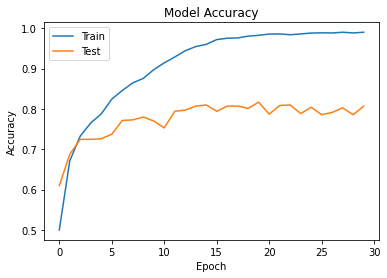

In [67]:
# Summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

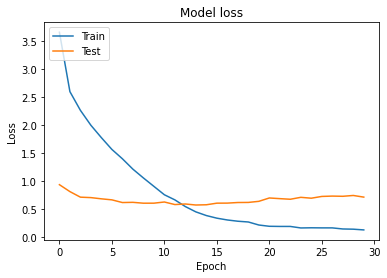

In [68]:
# Summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [89]:
predictions = model.predict_generator(validation_generator, steps=23)
predicted_classes = np.argmax(predictions, axis=1)

In [103]:
target_names = validation_generator.class_indices.keys()
print(classification_report(validation_generator.classes, predicted_classes, target_names=target_names))

                precision    recall  f1-score   support

          Mild       0.61      0.68      0.64        74
      Moderate       0.73      0.77      0.75       199
         No_DR       0.97      0.97      0.97       361
Proliferate_DR       0.53      0.32      0.40        59
        Severe       0.45      0.47      0.46        38

      accuracy                           0.81       731
     macro avg       0.66      0.64      0.64       731
  weighted avg       0.81      0.81      0.81       731



In [104]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(validation_generator.classes, predicted_classes)

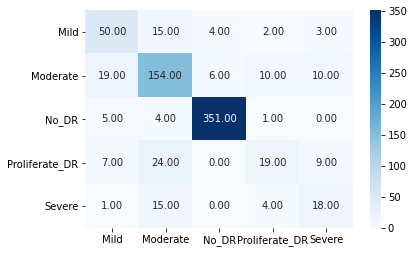

In [107]:
import seaborn as sns
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',xticklabels=target_names, yticklabels=target_names)